<a href="https://colab.research.google.com/github/samuelmcilrath/forest-fires/blob/main/forestfires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forest Fire Regression - Sam McIlrath and Olivia Creighton

## Data
Forest fires are highly detrimental to various communities and ecosystems. Their spread is determined by a variety of factors, including weather, topography, and ground cover. We wanted to determine if meteorological data and data on the ground cover could predict the spread of a forest fire. 

Features include:

**X, Y**: Spatial coordinates within a Monteshino Park map

**Month, day**: "jan" to "dec" and "mon" to "sun"

**FFMC**: Fine Fuel Moisture Code; the amount of moisture in the litter/fuel on the ground; relative measure of ease of ignition and flammability

**DMC**: Duff Moisture Code; the amount of moisture in the top layer of soil

**DC**: Drought Code; the amount of moisture of deeper soil

**ISI**: Initial Spread Index; expected rate of fire spread, based on windspeed and FFMC

**Temp**: Temperature in Celsius degrees

**RH**: Relative humidity in %

**Wind**: Wind speed in km/h

**Rain**: Outside rain in mm/m2

**Area**: Burned area in hectares

FFMC, DMC, and DC according to the FWI (https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi)

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

import sklearn

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score


import matplotlib.pyplot as plt
%matplotlib inline

# Set the path to the file you'd like to load
file_path = "C:\MAIN\School\ML\Sem Proj\forest-fires\forestfires.ipynb"

# Load the latest version
forest_fires = pd.read_csv("forestfires_dataset.csv")

print("First 5 records: \n", forest_fires.head())
  

First 5 records: 
    X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0


### Data Transformation

In [176]:
###Transform Data - get splits
forest_fires = forest_fires.drop(columns=['month', 'day']) #drop month and day columns

X = forest_fires.drop(columns=['area', 'X', 'Y'])
Y = forest_fires[['area']]

Y_log = np.log1p(Y) #skewed to 0, apply log 

# Standardize numerical features - this standardizes mean to 0
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_scaled, Y_log, test_size=0.2, random_state=42
)

# Split into training and test sets
X_train_base, X_test_base, y_train, y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42
)
##note 
#if going with classifier, try to make amounts of nonburn to burn 

In [177]:
### Data Transformation
count = 0
for i in forest_fires['area']:
    if i == 0:
        count += 1
print(count)    

# Count zeros in the area column
zero_count = (forest_fires['area'] == 0).sum()
print(f"Number of zeros in area column: {zero_count}")

# Let's also see the total number of rows for comparison
total_rows = len(forest_fires)
print(f"Total number of rows: {total_rows}")


247
Number of zeros in area column: 247
Total number of rows: 517


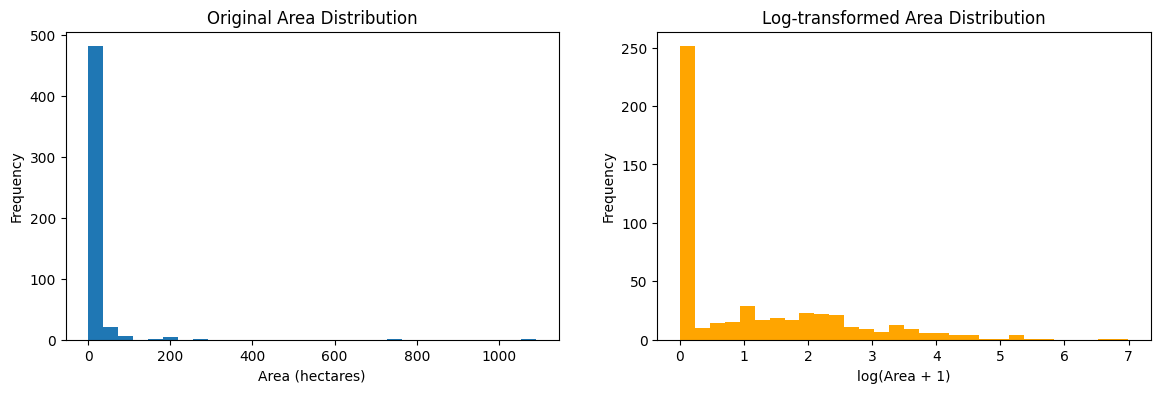

In [178]:
# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Original distribution
ax1.hist(forest_fires['area'], bins=30)
ax1.set_title('Original Area Distribution')
ax1.set_xlabel('Area (hectares)')
ax1.set_ylabel('Frequency')

# Log-transformed distribution
ax2.hist(np.log1p(forest_fires['area']), bins=30, color='orange')
ax2.set_title('Log-transformed Area Distribution')
ax2.set_xlabel('log(Area + 1)')
ax2.set_ylabel('Frequency')

plt.show()

## Regression Models

In [179]:
# A helper function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test, is_log_transformed=True):
    # Get predictions
    y_pred = model.predict(X_test)
    
    if is_log_transformed:
        # For log-transformed data, convert back to original scale
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_test)
    else:
        # For non-transformed data, use as is
        y_true = y_test
    
    print("Training set score: {:.2f}".format(model.score(X_train, y_train)))
    print("Test set score: {:.2f}".format(model.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f'RMSE: {rmse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R²: {r2:.3f}')
    return y_pred

#Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train_log)
print("\nLinear Regression Performance -----------")
print("-> log transformed")
lin_y_pred = evaluate_model(lin_reg, X_train, y_train_log, X_test, y_test_log, is_log_transformed=True)
print("-> no transformation")
lin_y_pred = evaluate_model(lin_reg, X_train, y_train, X_test, y_test, is_log_transformed=False)

#Ridge Regression (regularized linear model)
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train_log)
print("\nRidge Regression Performance -----------")
print("-> log transformed")
ridge_y_pred = evaluate_model(ridge, X_train, y_train_log, X_test, y_test_log, is_log_transformed=True)
print("-> no transformation")
ridge_y_pred = evaluate_model(ridge, X_train, y_train, X_test, y_test, is_log_transformed=False)

#Lasso Regression 
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train_log)
print("\nLasso Regression Performance -----------")
print("-> log transformed")
lasso_y_pred = evaluate_model(lasso, X_train, y_train_log, X_test, y_test_log, is_log_transformed=True)
print("-> no transformation")
lasso_y_pred = evaluate_model(lasso, X_train, y_train, X_test, y_test, is_log_transformed=False)

# Neural Network with MLPRegressor
mlp_reg = MLPRegressor(solver="adam", hidden_layer_sizes=(100), activation='logistic')
mlp_reg.fit(X_train, y_train_log)
print("\nNeural Network (MLPRegressor) Performance -----------")
print("-> log transformed")
mlp_y_pred = evaluate_model(mlp_reg, X_train, y_train_log, X_test, y_test_log, is_log_transformed=True)
print("-> no transformation")
mlp_y_pred = evaluate_model(mlp_reg, X_train, y_train, X_test, y_test, is_log_transformed=False)


Linear Regression Performance -----------
-> log transformed
Training set score: 0.02
Test set score: 0.00
RMSE: 109.960
MAE: 19.807
R²: -0.026
-> no transformation
Training set score: -0.05
Test set score: -0.03
RMSE: 110.135
MAE: 19.669
R²: -0.029

Ridge Regression Performance -----------
-> log transformed
Training set score: 0.02
Test set score: 0.00
RMSE: 109.960
MAE: 19.807
R²: -0.026
-> no transformation
Training set score: -0.05
Test set score: -0.03
RMSE: 110.135
MAE: 19.669
R²: -0.029

Lasso Regression Performance -----------
-> log transformed
Training set score: 0.00
Test set score: -0.00
RMSE: 109.995
MAE: 19.819
R²: -0.026
-> no transformation
Training set score: -0.05
Test set score: -0.03
RMSE: 110.145
MAE: 19.679
R²: -0.029


c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1650: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Neural Network (MLPRegressor) Performance -----------
-> log transformed
Training set score: 0.01
Test set score: 0.02
RMSE: 109.969
MAE: 19.738
R²: -0.026
-> no transformation
Training set score: -0.05
Test set score: -0.03
RMSE: 110.138
MAE: 19.650
R²: -0.029


# Ground vs. Weather
Some of the figures seem to be related to ground condition, while others are related to weather conditions. Do these different sets of factors affect the regression differently?

In [180]:
X_ground = forest_fires.drop(columns=['X','Y','wind','rain','temp','RH','area'])
X_weather = forest_fires.drop(columns=['X','Y','FFMC','DMC','DC','ISI','area'])

print(X.columns)
print(X_ground.columns)
print(X_weather.columns)

X_gscaled = scaler.fit_transform(X_ground)
X_wscaled = scaler.fit_transform(X_weather)

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_gscaled, Y_log
)

groundlr = LinearRegression().fit(X_train, y_train_log)

print("Ground training set R^2: {:.2f}".format(groundlr.score(X_train, y_train_log)))
print("Ground test set R^2: {:.2f}".format(groundlr.score(X_test, y_test_log)))

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_wscaled, Y_log
)

weatherlr = LinearRegression().fit(X_train, y_train_log)

print("Weather training set R^2: {:.2f}".format(weatherlr.score(X_train, y_train_log)))
print("Weather test set R^2: {:.2f}".format(weatherlr.score(X_test, y_test_log)))

#Somehow make a function that displays each combo of factors against each other

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'], dtype='object')
Index(['FFMC', 'DMC', 'DC', 'ISI'], dtype='object')
Index(['temp', 'RH', 'wind', 'rain'], dtype='object')
Ground training set R^2: 0.01
Ground test set R^2: -0.00
Weather training set R^2: 0.01
Weather test set R^2: 0.00


## Analyzing Correlations
After looking at these scores and their lackluster results we decided to check the correltations between the attributes and the target area.

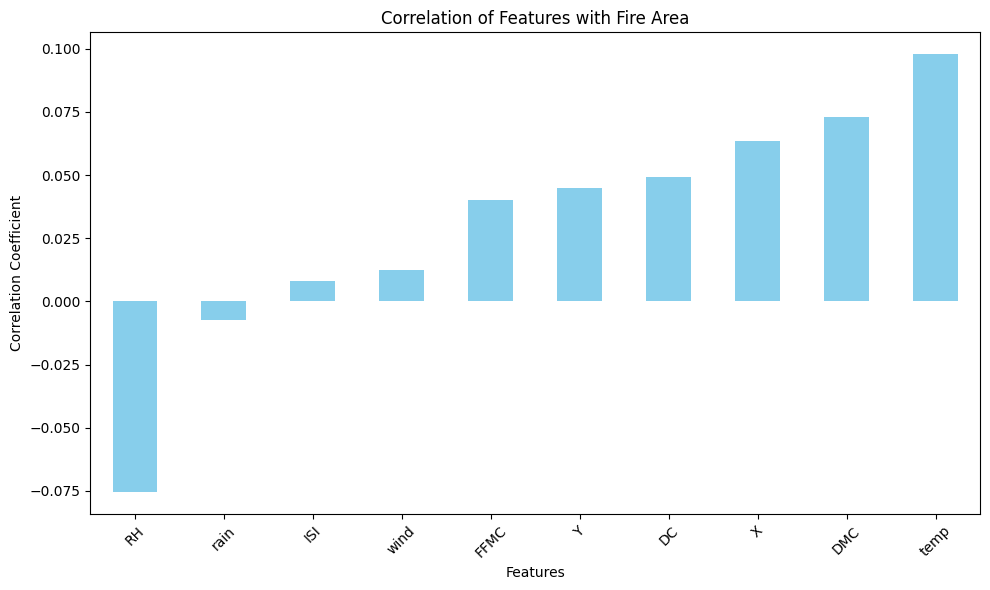

In [181]:
# Calculate correlations
correlation_matrix = forest_fires.corr()

plt.figure(figsize=(10, 6))
# Create bar plot of correlations with area
area_correlations = correlation_matrix['area'].drop('area')
area_correlations.sort_values().plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Fire Area')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Switching to Binary Classification

It is clear that regression simply won't work with the given correlations, or at least with the models that we have learned about. Given that a large portion of our target values are 0, it makes a lot of sense to switch this from a regression problem to binary classification where our two classes are area values of 0 and nonzero. This essentially makes it a question of, given certain weather conditions has or hasn't a fire occured?

## Data Transformation
Once again, we need to transform the data but just the Y this time, making our target values binary.

In [208]:
#transform to either 0 or 1
Y_bin = Y.copy()
Y_bin['area'] = (Y_bin['area'] != 0).astype(int)




# Split into training and test sets for classification
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, Y_bin, test_size=0.2, random_state=42
)

print("Number of fire cases (1):", (Y_bin['area'] == 1).sum())
print("Number of no-fire cases (0):", (Y_bin['area'] == 0).sum())
print("Unique values in area column:", forest_fires['area'].unique())
print("Number of zeros in area:", (forest_fires['area'] == 0).sum())
print("Number of non-zeros in area:", (forest_fires['area'] != 0).sum())

Number of fire cases (1): 270
Number of no-fire cases (0): 247
Unique values in area column: [0.00000e+00 3.60000e-01 4.30000e-01 4.70000e-01 5.50000e-01 6.10000e-01
 7.10000e-01 7.70000e-01 9.00000e-01 9.50000e-01 9.60000e-01 1.07000e+00
 1.12000e+00 1.19000e+00 1.36000e+00 1.43000e+00 1.46000e+00 1.56000e+00
 1.61000e+00 1.63000e+00 1.64000e+00 1.69000e+00 1.75000e+00 1.90000e+00
 1.94000e+00 1.95000e+00 2.01000e+00 2.14000e+00 2.29000e+00 2.51000e+00
 2.53000e+00 2.55000e+00 2.57000e+00 2.69000e+00 2.74000e+00 3.07000e+00
 3.50000e+00 4.53000e+00 4.61000e+00 4.69000e+00 4.88000e+00 5.23000e+00
 5.33000e+00 5.44000e+00 6.38000e+00 6.83000e+00 6.96000e+00 7.04000e+00
 7.19000e+00 7.30000e+00 7.40000e+00 8.24000e+00 8.31000e+00 8.68000e+00
 8.71000e+00 9.41000e+00 1.00100e+01 1.00200e+01 1.09300e+01 1.10600e+01
 1.12400e+01 1.13200e+01 1.15300e+01 1.21000e+01 1.30500e+01 1.37000e+01
 1.39900e+01 1.45700e+01 1.54500e+01 1.72000e+01 1.92300e+01 2.34100e+01
 2.42300e+01 2.60000e+01 2.6130

<>:8: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
<>:8: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
C:\Users\mac5p\AppData\Local\Temp\ipykernel_34788\2814567803.py:8: SyntaxWarning: 'int' object is not subscriptable; perhaps you missed a comma?
  plt.hist(Y_bin['area'] == 1[feature],


KeyError: 'FFMC'

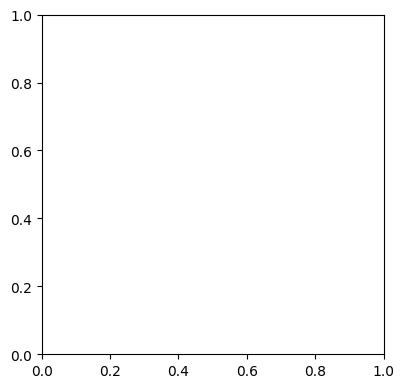

In [210]:
plt.figure(figsize=(15, 5*n_rows))
for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i+1)
    
    # Plot histograms for each class
    plt.hist(Y_bin['area'][feature], 
             alpha=0.5, label='No Fire', bins=20)
    plt.hist(Y_bin['area'] == 1[feature], 
             alpha=0.5, label='Fire', bins=20)
    
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()
plt.tight_layout()
plt.show()

# Ground vs. Weather
Some of the figures seem to be related to ground condition, while others are related to weather conditions. Do these different sets of factors affect the regression differently?

## Classification Models

Here we use logistic regression, svm, and MLP

# Ground vs. Weather
Some of the figures seem to be related to ground condition, while others are related to weather conditions. Do these different sets of factors affect the regression differently?

In [202]:
#Logistic Regression
log_reg = LogisticRegression(solver= 'liblinear',  C=100,max_iter= 10000)
log_reg.fit(X_train_bin, y_train_bin)  # Just use the 'area' column
y_pred = log_reg.predict(X_test_bin)

# Accuracy
print("Logistic Regression - Scores")
print("Training set score: {:.2f}".format(log_reg.score(X_train_bin, y_train_bin)))
print("Test set score: {:.2f}".format(log_reg.score(X_test_bin, y_test_bin)))

#SVM
svm = SVC(kernel='rbf')
svm.fit(X_train_bin, y_train_bin)
y_pred_svm = svm.predict(X_test_bin)
print("SVM - Scores")
print("Training set score: {:.2f}".format(svm.score(X_train_bin, y_train_bin)))
print("Test set score: {:.2f}".format(svm.score(X_test_bin, y_test_bin)))

mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp.fit(X_train_bin, y_train_bin)
y_pred_mlp = mlp.predict(X_test_bin)
print("MLP - Scores")
print("Training set score: {:.2f}".format(mlp.score(X_train_bin, y_train_bin)))
print("Test set score: {:.2f}".format(mlp.score(X_test_bin, y_test_bin)))

Logistic Regression - Scores
Training set score: 0.56
Test set score: 0.55
SVM - Scores
Training set score: 0.55
Test set score: 0.60
MLP - Scores
Training set score: 0.56
Test set score: 0.55


c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1124: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


What if it fits better as a polynomial?

In [184]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

X_poly = PolynomialFeatures(degree=8).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, Y_log)
lr_poly = LinearRegression().fit(X_train, y_train)
print("Polynomial training set R^2: {:.2f}".format(lr_poly.score(X_train, y_train)))
print("Polynomial test set R^2: {:.2f}".format(lr_poly.score(X_test, y_test)))

Polynomial training set R^2: 0.94
Polynomial test set R^2: -41115580.26


A liiiiiittle overfit

# to do:
SVR

In [185]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

c:\Python311\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
